#AAI-520 Final Project
##Students: Dan Arday, Kevin Akman
##Oct 21st, 2024

# Introduction and Project Description

In this project, we aimed to fine-tune GPT-2 using the Cornell Movie Dialogs Corpus. We began by conducting exploratory data analysis (EDA) to identify trends and remove unnecessary data. Afterward, we preprocessed the data by cleaning the text, translating non-English entries into English, and augmenting the dataset with additional dialogues. We trained our model three different times, with the final run lasting 31 epochs. Finally, we evaluated the model on various performance metrics. While our final model exhibited some quirks, such as occasional repetition, it proved effective in generating responses that convincingly mimic movie dialogue.


# Imports and Data Loading

#### Pip Installs and Imports

In [ ]:
!pip install gradio
!pip install langid
!pip install swifter
!pip install evaluate
!pip install huggingface_hub
!pip install datasets
!pip install sacremoses
!pip install bert-score
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2

In [ ]:
import os
import math
import pandas as pd
import swifter
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, MarianMTModel, MarianTokenizer, pipeline
from torch.cuda.amp import autocast, GradScaler  # Corrected import for autocast and GradScaler
from datasets import Dataset  # Ensure this refers to the Hugging Face Dataset
import langid
import kagglehub  # For downloading datasets
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm

#### Dataset Loading

In [ ]:
# Download latest version
path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1


#### Environment Set-Up

In [ ]:
# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = device
device

'cuda'

In [ ]:
if device == "cuda":
  # Set batch size and number of workers for faster operations
  batch_size = 32  # Increase based on A100 memory capacity
  num_workers = 8  # More workers to maximize data loading speed on A100
else:
  batch_size = 8
  num_workers = 1

print(batch_size, num_workers)

32 8


# EDA



#### **Step 1: Loading and Previewing the Data**

We started by examining the dataset files in the given directory. The dataset includes multiple text files, such as `movie_lines.txt`, `movie_characters_metadata.txt`, and `movie_conversations.txt`, among others. The file of interest for our analysis was `movie_lines.txt`, which contains the dialogues we used for fine-tuning our model.

We loaded the dialogues from `movie_lines.txt` using pandas, specifying the delimiter `+++$$$+++` to correctly parse the fields.

The dataset was loaded with the following columns:
- `line_id`: The unique identifier for each line of dialogue.
- `character_id`: The ID of the character speaking the line.
- `movie_id`: The ID of the movie in which the dialogue appears.
- `character_name`: The name of the character speaking the dialogue.
- `text`: The actual line of dialogue.

The text column became the focus of our analysis going forward and contains various lines from characters in different movies.


In [ ]:
# List all files in the dataset folder
files = os.listdir(path)
print("Files in dataset:", files)

# Adjust the filename based on actual content
dialogues_file = os.path.join(path, "movie_lines.txt")

# Load the dialogues with the correct delimiter '+++$$$+++'
dialogues = pd.read_csv(
    dialogues_file,
    sep=" \+\+\+\$\+\+\+ ",  # Regex pattern to handle the delimiter
    header=None,
    names=["line_id", "character_id", "movie_id", "character_name", "text"],
    engine='python',  # Required for regex separator
    encoding='latin1',
    on_bad_lines='skip'
)

# Preview the first few rows
dialogues.head()

Files in dataset: ['movie_conversations.txt', 'movie_lines.txt', 'chameleons.pdf', 'movie_titles_metadata.txt', 'raw_script_urls.txt', 'movie_characters_metadata.txt', 'README.txt', '.DS_Store']


,line_id,character_id,movie_id,character_name,text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [ ]:
print(dialogues.sample(15))

        line_id character_id movie_id  character_name  \
3558      L8189         u115       m7           ALICE   
981       L3394          u26       m2          CUTLER   
195615  L262210        u5747     m380           HOLLY   
268270  L552325        u7927     m536  MAJOR MANDRAKE   
7135     L30466         u257      m16     OLD SALIERI   
195631  L262125        u5738     m380        DR. ABEL   
218074  L367875        u6458     m429      LIEUTENANT   
233114  L428477        u6921     m463        MCMURPHY   
214643  L355503        u6365     m424        DOROTHEA   
30484   L221744         u956      m62           HARRY   
121743   L23705        u3583     m236        MELKONIS   
42940   L274044        u1292      m86            CLAY   
264731  L542344        u7824     m529            LUKE   
210304  L336096        u6208     m415           KLUTE   
265879  L547784        u7869     m532             JOE   

                                                     text  
3558    No, don't!  I gave 

#### **Step 2: Handling Missing Data**

Next, we examined the data for missing values. Initially, we found that the `character_name` column had 43 missing values, while the `text` column contained 267 missing entries. Since the `text` column was our focus we dropped rows where the `text` was missing.

After this cleaning step, we verified that all missing values in the `text` column were removed, ignoring missing values in any of the other columns.

In [ ]:
# Check for missing values in the dataset
print(dialogues.isnull().sum())

line_id             0
character_id        0
movie_id            0
character_name     43
text              267
dtype: int64


In [ ]:
# Summary statistics (for numerical columns, if any)
print(dialogues.describe())

# Data types of each column
print(dialogues.dtypes)

        line_id character_id movie_id character_name    text
count    304713       304713   304713         304670  304446
unique   304713         9035      617           5413  265808
top     L666256        u4525     m289           JACK   What?
freq          1          537     1530           3032    1684
line_id           object
character_id      object
movie_id          object
character_name    object
text              object
dtype: object


In [ ]:
# Drop rows where 'text' is NaN
dialogues = dialogues.dropna(subset=['text'])

# Verify that the missing values are removed
print(dialogues.isnull().sum())

line_id            0
character_id       0
movie_id           0
character_name    43
text               0
dtype: int64


#### **Step 3: Data Visulization**


#### Dialogue Lengths

Text(0.5, 1.0, 'Dialogue Lengths')

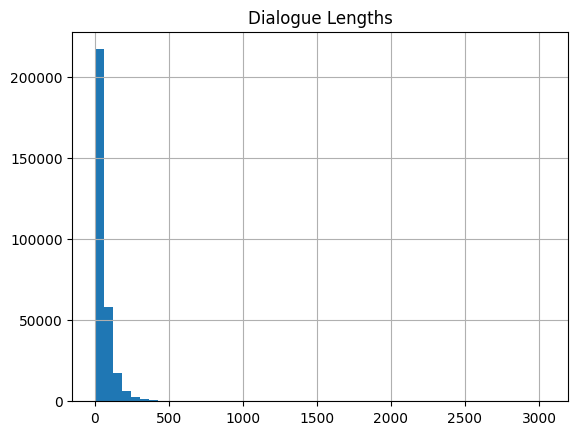

In [ ]:
# Add a column for dialogue lengths
dialogues['text_length'] = dialogues['text'].apply(len)

# Plot distribution of dialogue lengths
dialogues['text_length'].hist(bins=50)
plt.title('Dialogue Lengths')

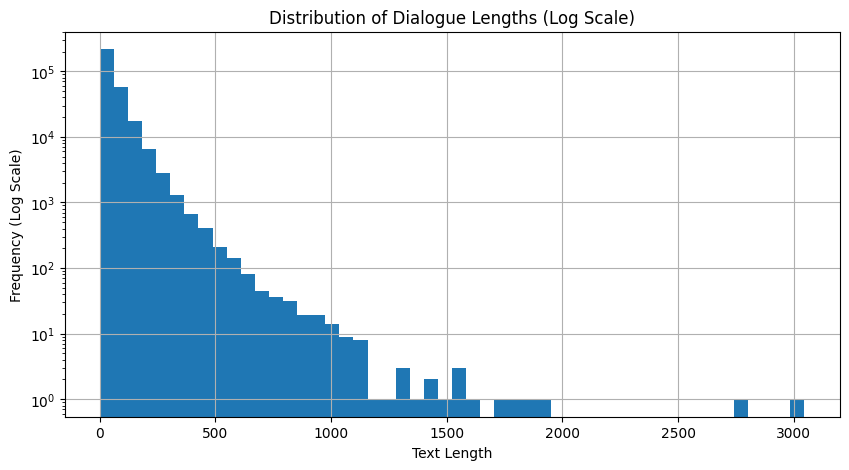

In [ ]:
# Plot with log scale
plt.figure(figsize=(10, 5))
dialogues['text_length'].hist(bins=50)
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.xlabel('Text Length')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Dialogue Lengths (Log Scale)')
plt.show()

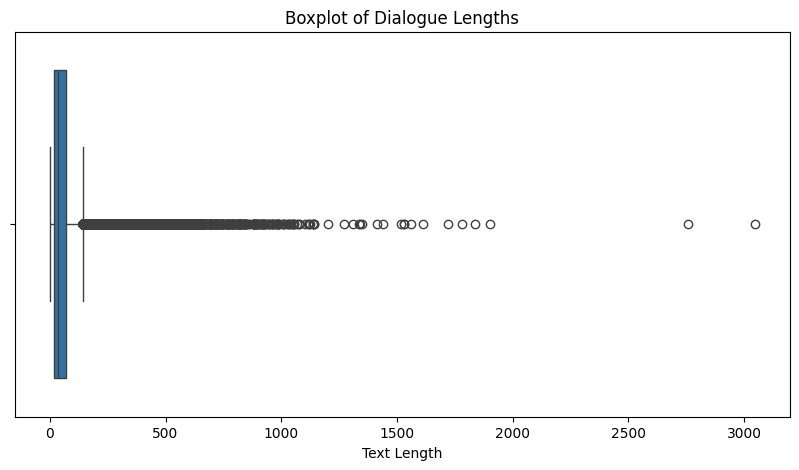

In [ ]:
# Boxplot of dialogue lengths
plt.figure(figsize=(10, 5))
sns.boxplot(x=dialogues['text_length'])
plt.xlabel('Text Length')
plt.title('Boxplot of Dialogue Lengths')
plt.show()

In [ ]:
# Shortest and longest dialogues
short_dialogues = dialogues.nsmallest(5, 'text_length')
long_dialogues = dialogues.nlargest(5, 'text_length')
print(short_dialogues[['text', 'text_length']])
print(long_dialogues[['text', 'text_length']])

      text  text_length
50062    .            1
50063    .            1
7       No            2
542     Hi            2
63752   K.            2
                                                     text  text_length
182894  Then let's begin with the story itself. It's a...         3046
27724   Shit O dear, that's enough to make me asthmati...         2757
197379  You should grab her and shake her             ...         1903
192409  So if I asked you about art you could give me ...         1836
217055  Yeah...So I go to her school for that for grad...         1782


**Summary on Dialogue Lengths:**


Our analysis a clear predominance of short exchanges. Most dialogues are short, as indicated by the clustering around lower text lengths in our boxplot an historgram. However, there are several outliers with much longer dialogue lengths, where a few instances have notably more content than the majority, with longest being 3046 characters. The linear-scale histogram supports this, with most dialogues under 500 characters.

Most importantly the shorter dialogues, *those under 5 characters*, like ".", "No", and "Hi", likely carry very little information for the model to learn conversation from, and will have to be dealt with appropriately in Pre-Processing.

#### WordCloud

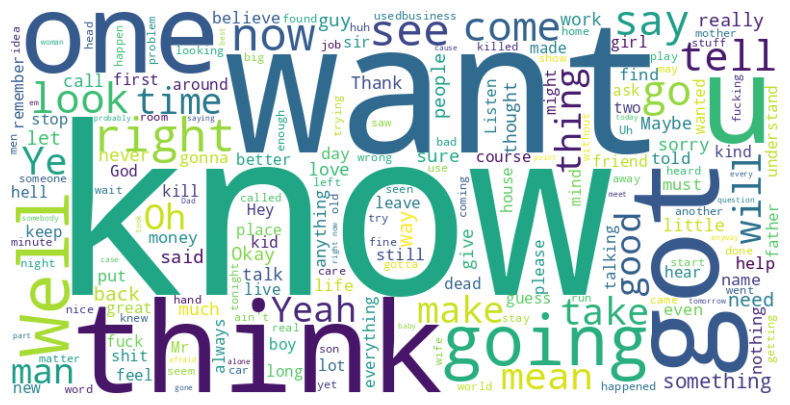

In [ ]:
# Combine all text data into one string
all_text = " ".join(dialogues['text'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This chart visualizes the most frequent words used in the dialogue dataset. Larger words indicate higher frequency. From the word cloud, we see that words like "**want**," "**know**," and "**think**" are among the most common, suggesting that the dataset's dialogue frequently revolves around expressions of desire, inquiry, and thought. This gives our dataset a gritty tone as one would expect in movie dialogues.

### Top 20 Bigrams and Trigrams

For context an n-gram is a contiguous sequence of n items from a given sample of text or speech.

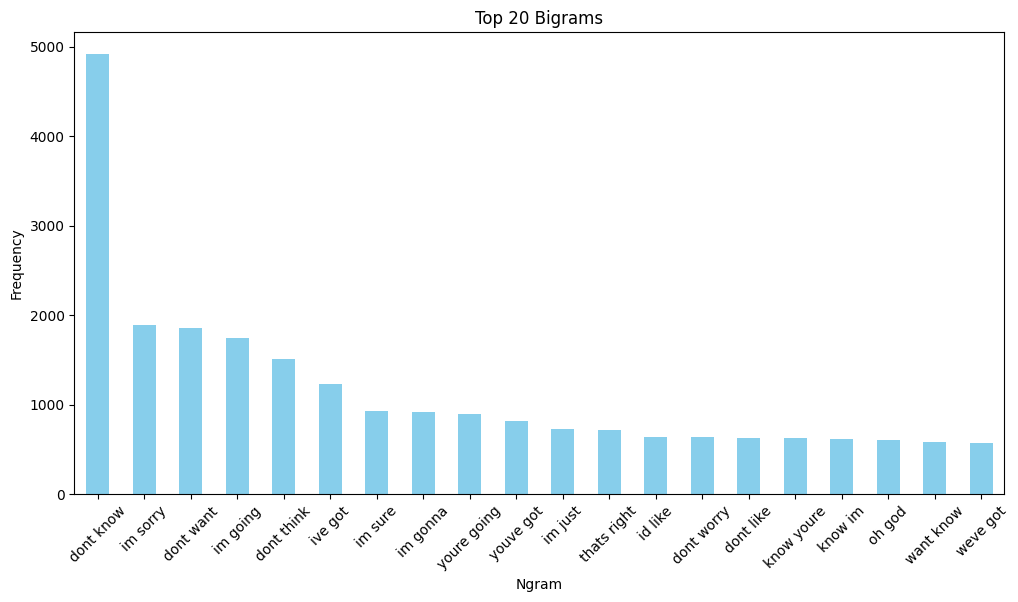

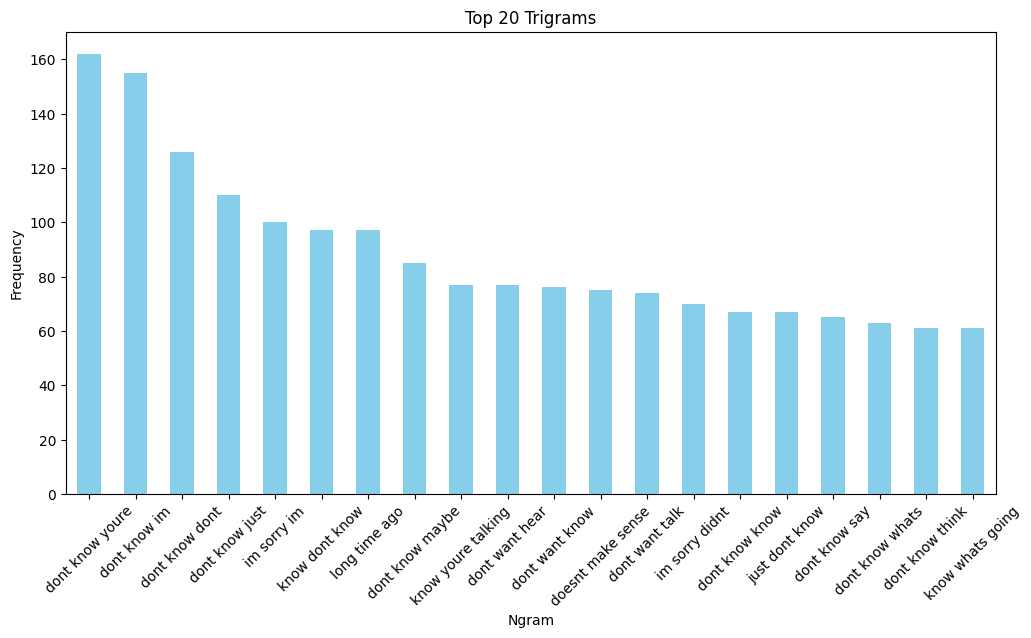

In [ ]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(r'[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    return text

# Apply preprocessing to dialogues
sampled_dialogues = dialogues['text'].apply(preprocess_text)

# Generate n-grams using CountVectorizer
def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Function to plot n-grams
def plot_ngrams(ngrams, title):
    ngrams_df = pd.DataFrame(ngrams, columns=['Ngram', 'Frequency'])
    ngrams_df.plot(kind='bar', x='Ngram', y='Frequency', legend=False, figsize=(12, 6), color='skyblue')
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Plot the top 20 bigrams
top_bigrams = get_top_ngrams(sampled_dialogues, ngram_range=(2, 2), n=20)
plot_ngrams(top_bigrams, 'Top 20 Bigrams')

# Plot the top 20 trigrams
top_trigrams = get_top_ngrams(sampled_dialogues, ngram_range=(3, 3), n=20)
plot_ngrams(top_trigrams, 'Top 20 Trigrams')

#### Analysis on N-Grams

The most common bigram are "don't know," followed by "I'm sorry" and "don't want." These common phrases suggest that uncertainty and apologies are prevalent themes in the dialogue. For he trigram analyis, "Don't know you're" and "don't know I'm" are the top trigrams, which reinforces the theme of uncertainty observed in the bigram analysis. Other frequent trigrams include "don't know don't" and "don't know maybe."

It seems that a lack of knowledge as a response is a common theme in our dataset.

### Initial Summary of EDA

- The dataset contains **304,713 rows**, with **265,808 unique lines of dialogue**
- The most frequent dialogue is **"What?"**, which appears **1,684 times**.
- **267 missing values** were identified in the `text` column, which were removed since the text data is critical for model training.
- The majority of dialogues are **under 500 characters** but the longest spans **3,046 characters**.
- **Very short dialogues** (less than 5 characters, e.g., ".", "No," "Hi") are common but provide limited training value and need to be addressed in preprocessing.
- Words like **"want," "know," and "think"** are the most frequent, reflecting themes of desire, inquiry, and thought.
- The most frequent n-grams are **"don't know"**, followed by **"I'm sorry"**, **"don't want."**, and **"don't know you're,"**

### EDA Conclusion

The dataset reflects a realistic, conversational tone typical of movie dialogues, with themes of uncertainty and apology being highly prominent.  Frequent n-grams like "don't know," "I'm sorry," and "don't want" further reinforce these themes. While the dataset offers a rich variety of responses, it is heavily skewed toward shorter dialogues. These shorter exchanges, required careful preprocessing to ensure effective model training. Ultimately, the dialogue's focus on hesitation, and conversational realism provided key insights into our final model’s performance.


# Preprcoessing the Data

### Initial Preprcoessing

This code defines a light preprocessing function that cleans the text by removing unwanted artifacts like metadata and HTML tags.

In [ ]:
# Function for light preprocessing (remove unwanted artifacts only)
def light_preprocess(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets (e.g., stage directions, metadata)
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags if present
    return text

dialogues['text'] = dialogues['text'].apply(light_preprocess)

### Handling different languages

Initially during our fist model built we opted to remove all langues from the dataset that weren't english. However this removed about 10,000 entries into the data. We noticed that our model seemed to repeat phrases, so in order to optimize the diversity of data we decided to translate the top 5 languages instead (German, French, Spanish, Dutch, Italian).

The following code does that by
  1. Batch classifying all text by language, which is placed in a new `language` column
  2. Uses a OPUS-MT LLM, developed by the Helsinki NLP Group, to translate`text` designated as one of the 5 target languages into English.
  3. Afterwards the model removes any remaining non-English texts.

In total we were able to translate about 1500 additional text dialogues into English for training by the model. While we could not get all non-English text translated, translation was a lenghty process, and we are happy with out results. Further efforts and time could've worked on prefecting this process.

In [ ]:
# Detect language using a shortened version of each text (to speed up detection)
def batch_langid_classify(texts, batch_size=1000):
    languages = []
    for i in range(math.ceil(len(texts) / batch_size)):
        batch = texts[i * batch_size:(i + 1) * batch_size]
        languages.extend([langid.classify(text[:100])[0] for text in batch])
    return languages

# Apply batch language detection
dialogues['language'] = batch_langid_classify(dialogues['text'].tolist(), batch_size=1000)

# Display the counts of texts by language
print( dialogues['language'].value_counts())

language
en    286493
de      3773
fr      2876
es      1788
nl      1220
       ...  
zu         2
jv         2
kk         1
ur         1
bs         1
Name: count, Length: 64, dtype: int64


In [ ]:
# Define the list of languages for translation (expand as needed)
languages = ['fr', 'es', 'de', 'nl', 'it']  # Translating the top 5 (French, Spanish, German, Dutch, Italian)

# Define function for batch translation using mixed precision
def batch_translate_texts(texts, model, tokenizer):
    if not texts:
        return []

    # Tokenize and translate the batch of texts
    tokenized_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    tokenized_texts = tokenized_texts.to(device)

    # Enable mixed precision for faster translation
    with torch.cuda.amp.autocast():
        translated = model.generate(**tokenized_texts)

    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

    return translated_texts

# Initialize 'translated_text' column for all dialogues
dialogues['translated_text'] = dialogues['text']  # Start with the original text

# Loop through multiple languages and apply batch translation
for lang in languages:
    print(f"Translating {lang} to English...")

    model_name = f'Helsinki-NLP/opus-mt-{lang}-en'  # Load appropriate model for the language
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name).to(device)  # Move model to GPU

    # Filter dialogues for the specific language
    lang_dialogues = dialogues[dialogues['language'] == lang].copy()

    # Check if there are dialogues to translate
    if lang_dialogues.empty:
        print(f"No dialogues detected in {lang}. Skipping...")
        continue

    # Split dialogues into batches and translate them
    for i in range(0, len(lang_dialogues), batch_size):
        batch = lang_dialogues['text'].iloc[i:i+batch_size].tolist()
        translated_batch = batch_translate_texts(batch, model, tokenizer)

        # Assign the translated batch back to the 'translated_text' column in the original DataFrame
        dialogues.loc[lang_dialogues.index[i:i+batch_size], 'translated_text'] = translated_batch

# Fill missing 'translated_text' with original text where translation was not needed
dialogues['translated_text'].fillna(dialogues['text'], inplace=True)

Translating fr to English...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translating es to English...


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translating de to English...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translating nl to English...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/790k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/316M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translating it to English...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/790k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/344M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
# Apply batch language detection to check if all dialogues are now in English
dialogues['language'] = batch_langid_classify(dialogues['translated_text'].tolist(), batch_size=1000)

# Print a summary of the language detection results
language_counts = dialogues['language'].value_counts()
print("Language distribution after translation:")
print(language_counts)

Language distribution after translation:
language
en    287966
de      3278
fr      2365
es      1480
it      1055
       ...  
se         3
jv         2
kk         1
ur         1
bs         1
Name: count, Length: 64, dtype: int64


Removes any remaining non-english Languages

In [ ]:
#Filter out any remaining non-English dialogues
dialogues = dialogues[dialogues['language'] == 'en']
print(f"Number of dialogues in English after translation: {len(dialogues)}")

Number of dialogues in English after translation: 286493


### Managing Context

This code adds contextual information to each dialogue entry. The purpose of the combined_text column is to concatenate the dialogue with its previous context (e.g., two previous turns). This combined context gives the model more information about the conversation and helps improve its ability to generate coherent responses in multi-turn dialogues.

In [ ]:
# Create a function to concatenate previous n lines for context
def concatenate_context(df, n=2):
    # Shift the text column and concatenate it for previous n rows
    for i in range(1, n + 1):
        df[f'prev_text_{i}'] = df['text'].shift(i)

    # Combine the previous context columns
    df['context'] = df[[f'prev_text_{i}' for i in range(1, n + 1)]].fillna('').agg(' '.join, axis=1)
    df['context'] = df['context'].str.strip()  # Remove extra spaces
    df['combined_text'] = df['context'] + ' ' + df['text']

    # Drop unnecessary columns
    df = df.drop(columns=[f'prev_text_{i}' for i in range(1, n + 1)] + ['context'])
    return df

# Apply the function to add context with the desired window size (e.g., 2 previous turns)
dialogues = concatenate_context(dialogues, n=2)

<ipython-input-31-bbfb9b2887e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'prev_text_{i}'] = df['text'].shift(i)
<ipython-input-31-bbfb9b2887e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'prev_text_{i}'] = df['text'].shift(i)


### Remove Short Dialogues

As discussed in our EDA we opted to remove all text entries with less than 5 characters, to prevent the model from training on meaningless data.

In [ ]:
# Set a minimum length threshold for dialogues (e.g., 5 tokens)
min_length = 5

# Filter out dialogues that are too short
filtered_dialogues = dialogues[dialogues['text_length'] >= min_length]

# Print the number of dialogues after filtering
print(f"Number of dialogues before filtering short phrases: {dialogues.shape[0]}")
print(f"Number of dialogues after filtering short phrases: {filtered_dialogues.shape[0]}")

Number of dialogues before filtering short phrases: 286493
Number of dialogues after filtering short phrases: 280119


### Augment Longer Dialogues

Initially when we trained our model it seemed to prefer shorter responses to combat this we decided to translate potentially missed exchanges into English to give it more data to learn from, as well as here we decided to augment additional lines of dialogues.

The following code illustrates how we used the T5 paraphrasing model to augment the dialogues. We employed techniques such as nucleus sampling, no-repeat n-gram, and a repetition penalty to ensure diversity in the generated text while maintaining coherence. The process involved:

- Sampling 20000 longer dialogues to ensure meaningful content.
- Using the T5-small model to generate paraphrases with various constraints to prevent excessive repetition and promote natural variation.
- Cleaning the punctuation from the generated text to ensure smooth integration into the dataset.
- Augmenting these paraphrased examples back into the original dataset to increase its size and variety.

In [ ]:
# Define the clean_punctuation function
def clean_punctuation(text):
    # Remove spaces before punctuation
    text = re.sub(r'\s+([,.!?])', r'\1', text)
    # Remove punctuation at the beginning of sentences
    text = re.sub(r'^[,.!?]+', '', text)
    # Remove all remaining parentheses from the string
    text = re.sub(r'[\(\)]', '', text)
    return text

# Load a paraphrasing pipeline (using T5) with GPU and mixed precision for faster processing
if 'paraphraser' not in globals():
  paraphraser = pipeline(
      "text2text-generation",
      model="t5-small",
      device=0 if torch.cuda.is_available() else -1,
      framework="pt"
  )

# Define a function for batch paraphrasing with post-processing
def augment_batch(dialogues):
    paraphrases = paraphraser(
        dialogues,
        max_length=200,
        truncation=True,
        num_return_sequences=1,
        no_repeat_ngram_size=3,  # Prevents repeating n-grams
        repetition_penalty=1.5,  # Adds a penalty for repeating words
        temperature=0.7,  # Adjusts randomness in generation
        top_k=50,             # Limits to the top 50 most likely tokens
        top_p=0.9,  # Sampling technique (nucleus sampling) for more diverse outputs
    )
    # Clean punctuation in the generated text
    cleaned_paraphrases = [clean_punctuation(p['generated_text']) for p in paraphrases]
    return cleaned_paraphrases

# Limit to 20000 examples for augmentation
sampled_dialogues = filtered_dialogues[filtered_dialogues['text_length'] > 100].sample(n=20000, random_state=13)

# Ensure the 'combined_text' column is string type
sampled_dialogues['combined_text'] = sampled_dialogues['combined_text'].astype(str)

# Apply the clean_punctuation function to the sampled dialogues
sampled_dialogues['combined_text'] = sampled_dialogues['combined_text'].apply(clean_punctuation)

# Convert the filtered dialogues into a Hugging Face Dataset
filtered_dataset = Dataset.from_pandas(sampled_dialogues[['combined_text']])

# Apply batch augmentation (paraphrasing) using map with batched=True
augmented_dataset = filtered_dataset.map(lambda batch: {'augmented_text': augment_batch(batch['combined_text'])}, batched=True, batch_size=32)

# Convert the augmented dataset back to a DataFrame
augmented_df = augmented_dataset.to_pandas()

# Append the newly augmented dialogues back to the original dialogues
augmented_df = augmented_df[['augmented_text']].rename(columns={'augmented_text': 'combined_text'})
final_dialogues = pd.concat([filtered_dialogues[['combined_text']], augmented_df], ignore_index=True)

# Print the final dataset size after augmentation
print(f"Final dataset size after augmentation: {final_dialogues.shape[0]}")

# Update the original dialogues DataFrame
dialogues = final_dialogues
print(dialogues.shape[0])


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Final dataset size after augmentation: 280319
280319


In [ ]:
# Cleans memory (Execute when needed)
del paraphraser
torch.cuda.empty_cache()

In [ ]:
final_dialogues.sample(20)

,combined_text
42688,Why not? You need trees for an avenue. Rosehil...
246558,"I'm not certain, Mister President. But I beli..."
46360,"I knew you were trouble. Trouble...is, if we b..."
247528,"Yeah, hey I saw your album at Musicland up at ..."
5679,"The embryo, the second form, hosts in the vict..."
57403,I wouldn't let Adam or Ryan see you doing it. ...
239585,My family did everything they could - hired th...
220976,You mean they don't have hookers. Every place ...
280297,"the Oriental. it getting Spooky? Curly Bill, h..."
179461,"Oh, good... Come in, come in. Mm-mm!"


***Note:*** In the code and output above you may notice that we only generated 100 new dialogues despite claiming to have generated 20,0000. We did in-fact generate 20,0000 when training the final version of our model, however our colab unfortunately deleted this output.
We could not regenerate all 20,000 dialogues in time for the deadline, so for examples purposes we generated 100 new dialogues here for you to observe. These are qualitatively of the same kind as the ones used to train our model and will be used as our examples going forward.

In [ ]:
dialogues.columns

Index(['combined_text'], dtype='object')

***Also Note:*** That after completing these preprocessing steps `combined_text` became the final column that we changed our model on, as opposed to `text` which is what we originally selected.

#### Conlusion on Augmnetation

After augmenting 20,000 new dialouges our final size of our dataset was about 300,000 entries, or about 6% larger after other steps that removed meaningless short entries.

### Test/Train Split

Here we split our data into train/validation/test sets with a 80%/10%/10%, split of each. This split is later used for our tests on Coherence and Perplexity in the final parts, as well as BLEU/ROUGE Scores.

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train (80%), validation (10%), and test (10%)
train_data, temp_data = train_test_split(dialogues, test_size=0.2, random_state=13)  # 80% train, 20% temp (val/test)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=13)  # 50/50 split for val/test


### Tokenize for GPT-2 and Final Preprocessing

In [ ]:
# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set pad token as the end-of-sequence token

# Tokenization function that outputs a tensor
def tokenize_text(text):
    # Convert text to token tensor and ensure it's a tensor with no unnecessary dimensions
    tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=512).squeeze(0)
    return tokens

# Apply tokenization to each dataset and filter out short sequences
train_data['tokens'] = train_data['combined_text'].apply(tokenize_text)
train_data = train_data[train_data['tokens'].apply(lambda x: x.size(0) > 10)]  # Only keep dialogues with more than 10 tokens

val_data['tokens'] = val_data['combined_text'].apply(tokenize_text)
val_data = val_data[val_data['tokens'].apply(lambda x: x.size(0) > 10)]

test_data['tokens'] = test_data['combined_text'].apply(tokenize_text)
test_data = test_data[test_data['tokens'].apply(lambda x: x.size(0) > 10)]


#Sanity Check
print(train_data['tokens'].head())
print(train_data['tokens'].iloc[0])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

35347     [tensor(8585), tensor(1936), tensor(812), tens...
117213    [tensor(1544), tensor(338), tensor(21024), ten...
47404     [tensor(3347), tensor(750), tensor(407), tenso...
362       [tensor(32), tensor(376), tensor(2194), tensor...
161682    [tensor(5195), tensor(407), tensor(30), tensor...
Name: tokens, dtype: object
tensor([ 8585,  1936,   812,    13,  3966,   645,    13,  4231,   345, 26471,
          502,    30,  3894,   703,   890,   468,   428,   587,  1016,   319,
           13])


### Prepare for Training

In [ ]:
class DialogueDataset(Dataset):
    def __init__(self, dialogues):
        self.dialogues = dialogues['tokens'].tolist()  # Convert to list of tensors

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        # Handle cases where idx is a list (batch processing)
        if isinstance(idx, list):
            dialogue_tensor = [self.dialogues[i] for i in idx]  # Get items for each index in idx
        else:
            dialogue_tensor = self.dialogues[idx]  # Handle single index

        # Ensure the dialogue_tensor or its elements are tensors, convert if needed
        if isinstance(dialogue_tensor, list):
            dialogue_tensor = [torch.tensor(item) if isinstance(item, list) else item for item in dialogue_tensor]
        elif isinstance(dialogue_tensor, list):  # Handle cases where it's still a list
            dialogue_tensor = torch.tensor(dialogue_tensor)

        return dialogue_tensor


def collate_fn(batch):
    # Pad the batch of sequences to the same length
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
    return batch_padded


# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set pad token as the end-of-sequence token


# Create datasets and data loaders
train_dataset = DialogueDataset(train_data)
val_dataset = DialogueDataset(val_data)
test_dataset = DialogueDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

#Sanity Check
first_batch = next(iter(train_dataloader))
print(f"First batch shape: {first_batch.shape}")
print(f"First batch content: {first_batch}")

First batch shape: torch.Size([32, 201])
First batch content: tensor([[ 2949,    11,   356,  ..., 50256, 50256, 50256],
        [ 3666,  1793,   986,  ..., 50256, 50256, 50256],
        [   40,   373, 14104,  ..., 50256, 50256, 50256],
        ...,
        [ 1639,   836,   470,  ..., 50256, 50256, 50256],
        [ 2061,   466,   345,  ..., 50256, 50256, 50256],
        [   40,  1392,   606,  ..., 50256, 50256, 50256]])


# Fine-tuning GPT-2

### Model Set-UP

In [ ]:
num_epochs = 31  # Number of training epochs

In [ ]:
from transformers import GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

# Load the GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.train()  # Set the model to training mode

# Move the model to GPU
model.to(device)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set the total number of steps based on the number of batches and epochs
total_steps = len(train_dataloader) * num_epochs  # Use num_epochs defined in Step 0

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Training with Early Stopping

Here we trained with the potential with early stopping. We had no idea if 31 epochs would be enough, but we added in the potentital for early stopping to attempt to reduce training time. We also utilized the GPU, a larger batch size of 32, and greater number of workers for faster training times. In total our final model trained in a little over 5 hours on an A100.

In [ ]:
# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

# Define Early Stopping parameters
patience = 3  # Stop if validation loss doesn't improve after 3 epochs
best_val_loss = float('inf')  # Best validation loss starts as infinity
patience_counter = 0  # Counts epochs without improvement

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):  # Use num_epochs defined in Step 0
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training loop
    model.train()  # Ensure the model is in training mode
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        batch = batch.to(device)
        attention_mask = (batch != tokenizer.pad_token_id).to(device)

        # Mixed precision forward pass
        with autocast():
            outputs = model(batch, attention_mask=attention_mask, labels=batch)
            loss = outputs.loss

        # Accumulate training loss for monitoring
        train_loss += loss.item()

        # Backward pass with scaling
        scaler.scale(loss).backward()

        # Optimizer step with scaled gradients
        scaler.step(optimizer)
        scaler.update()

        # Clear gradients
        optimizer.zero_grad()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Training loss after epoch {epoch + 1}: {avg_train_loss}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = val_batch.to(device)
            attention_mask = (val_batch != tokenizer.pad_token_id).to(device)

            # Mixed precision validation forward pass
            with autocast():
                val_outputs = model(val_batch, attention_mask=attention_mask, labels=val_batch)
                val_loss += val_outputs.loss.item()

            num_batches += 1

    avg_val_loss = val_loss / num_batches
    val_losses.append(avg_val_loss)
    print(f"Validation loss after epoch {epoch + 1}: {avg_val_loss}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter
        # Save the model if validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
        print("Validation loss improved, model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # Stop training if patience is exceeded


Epoch 1/31


100%|██████████| 7467/7467 [11:21<00:00, 10.96it/s]

Training loss after epoch 1: 1.3066059564696397


Validation loss after epoch 1: 1.2269654901622449
Validation loss improved, model saved.
Epoch 2/31


100%|██████████| 7467/7467 [11:23<00:00, 10.92it/s]

Training loss after epoch 2: 1.2127442683970193


Validation loss after epoch 2: 1.1801423805684044
Validation loss improved, model saved.
Epoch 3/31


100%|██████████| 7467/7467 [11:23<00:00, 10.93it/s]

Training loss after epoch 3: 1.1514955061944723


Validation loss after epoch 3: 1.1423108487427873
Validation loss improved, model saved.
Epoch 4/31


100%|██████████| 7467/7467 [11:21<00:00, 10.96it/s]

Training loss after epoch 4: 1.1063928780337646


Validation loss after epoch 4: 1.1076599336219293
Validation loss improved, model saved.
Epoch 5/31


100%|██████████| 7467/7467 [11:21<00:00, 10.96it/s]

Training loss after epoch 5: 1.0614992736397106


Validation loss after epoch 5: 1.0761528703398062
Validation loss improved, model saved.
Epoch 6/31


100%|██████████| 7467/7467 [11:21<00:00, 10.95it/s]

Training loss after epoch 6: 1.0172110562868446


Validation loss after epoch 6: 1.0460330228414985
Validation loss improved, model saved.
Epoch 7/31


100%|██████████| 7467/7467 [11:20<00:00, 10.97it/s]

Training loss after epoch 7: 0.9800610582748218


Validation loss after epoch 7: 1.016183374780659
Validation loss improved, model saved.
Epoch 8/31


100%|██████████| 7467/7467 [11:21<00:00, 10.96it/s]

Training loss after epoch 8: 0.9437782124006175


Validation loss after epoch 8: 0.9886109689190761
Validation loss improved, model saved.
Epoch 9/31


100%|██████████| 7467/7467 [11:22<00:00, 10.95it/s]

Training loss after epoch 9: 0.9101766088396985


Validation loss after epoch 9: 0.9621569629782528
Validation loss improved, model saved.
Epoch 10/31


100%|██████████| 7467/7467 [11:20<00:00, 10.98it/s]

Training loss after epoch 10: 0.8796231703468798


Validation loss after epoch 10: 0.9376231598841301
Validation loss improved, model saved.
Epoch 11/31


100%|██████████| 7467/7467 [11:21<00:00, 10.96it/s]

Training loss after epoch 11: 0.8475181172415165


Validation loss after epoch 11: 0.9136771334761981
Validation loss improved, model saved.
Epoch 12/31


100%|██████████| 7467/7467 [11:20<00:00, 10.98it/s]

Training loss after epoch 12: 0.8226152402027649


Validation loss after epoch 12: 0.8926873993312011
Validation loss improved, model saved.
Epoch 13/31


100%|██████████| 7467/7467 [11:19<00:00, 10.98it/s]

Training loss after epoch 13: 0.7974506185502432


Validation loss after epoch 13: 0.8716999355232945
Validation loss improved, model saved.
Epoch 14/31


100%|██████████| 7467/7467 [11:22<00:00, 10.94it/s]

Training loss after epoch 14: 0.7724203430131144


Validation loss after epoch 14: 0.8512360836504869
Validation loss improved, model saved.
Epoch 15/31


100%|██████████| 7467/7467 [11:20<00:00, 10.97it/s]

Training loss after epoch 15: 0.7474617945835806


Validation loss after epoch 15: 0.8341816195009607
Validation loss improved, model saved.
Epoch 16/31


100%|██████████| 7467/7467 [11:20<00:00, 10.98it/s]

Training loss after epoch 16: 0.725440781034187


Validation loss after epoch 16: 0.8153867455921285
Validation loss improved, model saved.
Epoch 17/31


100%|██████████| 7467/7467 [11:20<00:00, 10.98it/s]

Training loss after epoch 17: 0.7060730314081543


Validation loss after epoch 17: 0.8012828291802642
Validation loss improved, model saved.
Epoch 18/31


100%|██████████| 7467/7467 [11:21<00:00, 10.96it/s]

Training loss after epoch 18: 0.6872431772695067


Validation loss after epoch 18: 0.7842001384183988
Validation loss improved, model saved.
Epoch 19/31


100%|██████████| 7467/7467 [11:19<00:00, 10.98it/s]

Training loss after epoch 19: 0.6693064399383881


Validation loss after epoch 19: 0.7713159492650175
Validation loss improved, model saved.
Epoch 20/31


100%|██████████| 7467/7467 [11:20<00:00, 10.97it/s]

Training loss after epoch 20: 0.6499037869455219


Validation loss after epoch 20: 0.7548436635439094
Validation loss improved, model saved.
Epoch 21/31


100%|██████████| 7467/7467 [11:14<00:00, 11.08it/s]

Training loss after epoch 21: 0.6373076443673298


Validation loss after epoch 21: 0.7406107377763479
Validation loss improved, model saved.
Epoch 22/31


100%|██████████| 7467/7467 [11:15<00:00, 11.06it/s]

Training loss after epoch 22: 0.6198137049412686


Validation loss after epoch 22: 0.7255818740937389
Validation loss improved, model saved.
Epoch 23/31


100%|██████████| 7467/7467 [11:15<00:00, 11.06it/s]

Training loss after epoch 23: 0.6064691119034702


Validation loss after epoch 23: 0.7108638493196612
Validation loss improved, model saved.
Epoch 24/31


100%|██████████| 7467/7467 [11:16<00:00, 11.04it/s]

Training loss after epoch 24: 0.5905302786014478


Validation loss after epoch 24: 0.700559805671842
Validation loss improved, model saved.
Epoch 25/31


100%|██████████| 7467/7467 [11:14<00:00, 11.07it/s]

Training loss after epoch 25: 0.5785615917919342


Validation loss after epoch 25: 0.6883913391215898
Validation loss improved, model saved.
Epoch 26/31


100%|██████████| 7467/7467 [11:17<00:00, 11.02it/s]

Training loss after epoch 26: 0.5663250919520751


Validation loss after epoch 26: 0.6772266606096282
Validation loss improved, model saved.
Epoch 27/31


100%|██████████| 7467/7467 [11:18<00:00, 11.01it/s]

Training loss after epoch 27: 0.5532015965129216


Validation loss after epoch 27: 0.6686698835207512
Validation loss improved, model saved.
Epoch 28/31


100%|██████████| 7467/7467 [11:17<00:00, 11.02it/s]

Training loss after epoch 28: 0.5431906290983952


Validation loss after epoch 28: 0.6583291192796297
Validation loss improved, model saved.
Epoch 29/31


100%|██████████| 7467/7467 [11:19<00:00, 10.99it/s]

Training loss after epoch 29: 0.5310586600422109


Validation loss after epoch 29: 0.6515324634102989
Validation loss improved, model saved.
Epoch 30/31


100%|██████████| 7467/7467 [11:13<00:00, 11.09it/s]

Training loss after epoch 30: 0.5207627547905598


Validation loss after epoch 30: 0.64139488774972
Validation loss improved, model saved.
Epoch 31/31


100%|██████████| 7467/7467 [11:17<00:00, 11.02it/s]

Training loss after epoch 31: 0.5093942883464249


Validation loss after epoch 31: 0.6356106513445076
Validation loss improved, model saved.


### Evaluation of Training

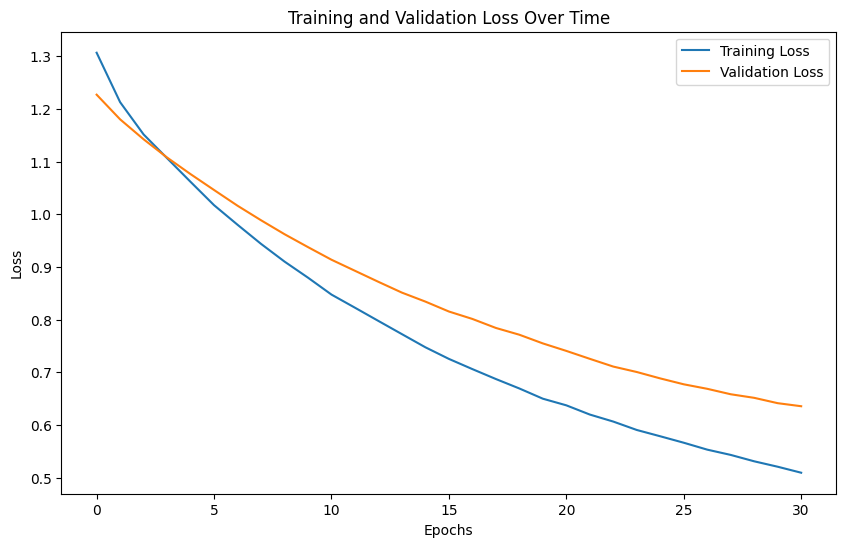

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

**Analysis:**

After training for 31 epochs, our results show that both training and validation loss consistently decreased over time. Initially, the validation loss was slightly higher than the training loss, which is typical as the model adapts to unseen data. By the end of the 30th epoch, the model showed steady improvement in both metrics. Our model likely could've benefited from more training, though the gap between the training and validation loss might require monitoring for potential overfitting in future epochs.

### Saving the fine-tuned model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define output directory on Google Drive
model_output_dir = "/content/drive/MyDrive/gpt2_fine_tuned_model_31"

# Save the fine-tuned model and tokenizer
model.save_pretrained(model_output_dir)
tokenizer.save_pretrained(model_output_dir)

print(f"Model saved to {model_output_dir}")

#### Saves a zipped version and downloads it locally

In [ ]:
import shutil

# Zip the model directory
shutil.make_archive("/content/drive/MyDrive/gpt2_fine_tuned_model_31", 'zip', model_output_dir)

print("Model zipped and saved to Google Drive.")

from google.colab import files

# Download the zip file
files.download("/content/drive/MyDrive/gpt2_fine_tuned_model_31.zip")

# Tests

#### Reload the model if necessary

In [ ]:
# Mount the Google Drive if necessary
from google.colab import drive
drive.mount('/content/drive')

# Reload the model and tokenizer from Google Drive
model_output_dir = '/content/drive/MyDrive/gpt2_fine_tuned_model_31'
model = GPT2LMHeadModel.from_pretrained(model_output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_output_dir)

# Check if model is on GPU
next(model.parameters()).device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cpu')

In [ ]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the correct device
model.to(device)

# Set the model to evaluation mode (for inference/testing)
model.eval()

# Verify that the model is on the correct device
print(f"Model is on: {next(model.parameters()).device}")

Model is on: cuda:0


### Single Prompt Generation

In [ ]:
# Function to generate a response using the loaded model
def generate_response(prompt, max_new_tokens=50):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
    with torch.no_grad():
        output = model.generate(input_ids, max_new_tokens=max_new_tokens, attention_mask=attention_mask)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example test prompt and input text
test_prompts = ["This is a serious meeting on automated technology. Our first topic is", "Quantum superposition will", "Once upon a time"]

# Generate outputs with different token lengths
generated_output_50 = generate_response(test_prompts[2], max_new_tokens=50)
generated_output_512 = generate_response(test_prompts[2], max_new_tokens=512)

# Print the generated outputs
print("Generated Output for:")

print("\nTest prompt 1:")
print(generate_response(test_prompts[0]))

print("\nTest prompt 2:")
print(generate_response(test_prompts[1]))


print("\nTest prompt 3 (with 50 new tokens):")
print(generated_output_50)

print("\nTest prompt 3 (with 512 new tokens):")
print(generated_output_512)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Output for:

Test prompt 1:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


This is a serious meeting on automated technology. Our first topic is trans- plendid. Yeah, well, I'm a little sensitive about my hair. It started falling out ten years ago. So I did something about it.

Test prompt 2:
Quantum superposition will render the metal impassable. I'll be unconscious. I'm not sure. I don't know.

Test prompt 3 (with 50 new tokens):
Once upon a time there was a rich king... ...and he had him a son and a daughter and they all lived in a castle over in Africa. Well, one day this King got taken away by bad men and before he got took off he told his son

Test prompt 3 (with 512 new tokens):
Once upon a time there was a rich king... ...and he had him a son and a daughter and they all lived in a castle over in Africa. Well, one day this King got taken away by bad men and before he got took off he told his son to kill anyone that tried to steal their gold, and before long these bad men come back and -- The king said to the other King, "What happened to your gold?" We

****Analysis:****

- Topic Consistency: In shorter responses, the model manages to remain somewhat on topic but veers off into irrelevant content quite quickly (as seen in the first prompt). This is a typical behavior in large language models where they capture tone but struggle with longer, more complex contexts. (Radford et al., 2019)
- Vagueness and Fragmentation: For scientific or abstract prompts, such as the second one, the model gives vague responses that imply uncertainty. This likely due to the use of words and n-grams of uncertainty like "what" and "don't know" as explained before.
- Repetition in Long Sequences: The 512-token output demonstrates the model’s tendency to fall into repetitive loops during longer generation, which reflects limitations in maintaining coherent, long-form dialogue or stories without significant repetition.

Overall, the results show that the model performs well on short, general prompts but struggles with maintaining relevance and coherence in both highly technical and extended outputs.

### Multi-Turn Conversation Test

Here we conducted two multi-turn conversation tests.

In the first test, we built up the context with each user input and model response, growing the input size for the model at each turn. To manage this, we recomputed both the `input_ids` and the `attention_mask` after every turn. While this allowed for multi-turn interactions, the context grew too large and repetitive responses started appearing. The full conversation history led to the model repeating itself.

In the second test, we trimmed the context to avoid these issues. After each response, we updated the context but limited it to the most recent turns, ensuring that the model didn’t have access to the entire conversation history. Additionally, if the model started its response by repeating the user's input, we stripped this redundant part before continuing. This method kept the conversation relevant without overwhelming the model with too much historical data. Trimming the context allowed us to control the size of the input and improved the relevance and coherence of the responses.

We would definitely choose the second approach in a deployed sense.


*This block repeats the response back.*

In [ ]:
# Define the maximum context size (number of tokens)
max_context_length = 512

# Start by getting the user's input
context = input("You: ")  # Initial user input
for i in range(3):
    # Encode the current context and move to the same device as the model
    input_ids = tokenizer.encode(context, return_tensors='pt').to(device)

    # Generate attention mask for current input and move to the same device as the model
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

    # Generate response
    output = model.generate(input_ids, max_new_tokens=50, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"Model: {response}")

    # Get user input for the next turn
    if i < 2:
      user_input = input("You: ")

    # Update the context by appending the latest user input and model response
    context += " " + user_input + " " + response

    # Trim context if it exceeds the max token length
    context_ids = tokenizer.encode(context)
    if len(context_ids) > max_context_length:
        context_ids = context_ids[-max_context_length:]  # Keep only the most recent tokens
        context = tokenizer.decode(context_ids, skip_special_tokens=True)

You: Hello! How are you today?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: Hello! How are you today? I'm fine.
You: Good! Tell me about AI.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: Hello! How are you today? Good! Tell me about AI. Hello! How are you today? I'm fine.
You: That's not helpful...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: Hello! How are you today? Good! Tell me about AI. Hello! How are you today? I'm fine. That's not helpful... Hello! How are you today? Good! Tell me about AI. Hello! How are you today? I'm fine.


*This block attempts to strip the context, so responses aren't repeated.*

In [ ]:
# Define the maximum context size (number of tokens)
max_context_length = 512

# Start by getting the user's input
context = input("You: ")  # Initial user input
for i in range(3):
    # Encode the current context and move to the same device as the model
    input_ids = tokenizer.encode(context, return_tensors='pt').to(device)

    # Generate attention mask for current input and move to the same device as the model
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

    # Generate response
    output = model.generate(input_ids, max_new_tokens=50, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    # Check if the response starts by repeating the user input
    if response.startswith(context):
        response = response[len(context):].strip()  # Remove the repeated part

    print(f"Model: {response}")

    # Get user input for the next turn (if not the last turn)
    if i < 2:
        user_input = input("You: ")

        # Update the context by appending the latest user input and the cleaned model response
        context += " " + user_input + " " + response

        # Trim context if it exceeds the max token length
        context_ids = tokenizer.encode(context)
        if len(context_ids) > max_context_length:
            context_ids = context_ids[-max_context_length:]  # Keep only the most recent tokens
            context = tokenizer.decode(context_ids, skip_special_tokens=True)

You: Hello! How are you today?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: I'm fine.
You: Can you tell me something about AI?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: 
You: Nothing at all??


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: What's wrong?


### Perplexity Test

In [ ]:
def calculate_perplexity(model, dataloader, tokenizer, device):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            attention_mask = (batch != tokenizer.pad_token_id).to(device)

            # Get model outputs with an attention mask
            outputs = model(batch, attention_mask=attention_mask, labels=batch)
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    perplexity = math.exp(avg_loss)  # Exponentiate the average negative log-likelihood loss
    return perplexity

# Calculate perplexity on the test set
test_perplexity = calculate_perplexity(model, test_dataloader, tokenizer, device)
print(f"Perplexity on test set: {test_perplexity}")


Perplexity on test set: 1.8849062026692667


Perplexity measures how well a model predicts a sequence of words, with lower values representing better predictions, and 1 being the best.

Our score of **~1.88** suggests that our model is generating text that closely aligns with the natural structure of the test data, showing that it has learned to generate coherent and contextually appropriate dialogue. This score demonstrates that the model is well-tuned for the task of dialogue generation.

### Coherence Test

In [ ]:
prompts = [
    "Tell me a joke.",
    "What is the weather like today?",
    "Explain the theory of relativity.",
    "How do I bake a cake?"
]

for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)  # Move input_ids to GPU
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)  # Create attention mask and move to GPU

    # Generate response with attention mask
    output = model.generate(input_ids, max_new_tokens=50, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"Prompt: {prompt}")
    print(f"Response: {response}\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Tell me a joke.
Response: Tell me a joke.  Do you think I'm making up this whole thing?  Just to get some answers.  There's gotta be something I can do.  Something I can say to make this up to you?  You've gotta do something.  You



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: What is the weather like today?
Response: What is the weather like today? I don't know.  I'm not sure.  I have to make a stop in Vegas.  Business to finish.  Then maybe I'll head to Santa Barbara.  I might be able to pick up some action there.  Of



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Explain the theory of relativity.
Response: Explain the theory of relativity. Explain the worm's sense of identity. I don't know.  I'm not sure.  But I think we should go.  It might make things a lot easier.

Prompt: How do I bake a cake?
Response: How do I bake a cake?  How do I make a living?  I'm not making a living.  I'm just doing this.  I'm giving my kids a chance to live.  I'm giving you a chance to live.  I'm giving you a



**Analysis**

These tests evaluate how well the model generates meaningful, contextually appropriate, and logically consistent responses. Here we can see that the  model often repeats the prompt, which is a common issue when it struggles to generate coherent or original content. It also frequently drift from the topic, especially in technical or specific prompts. This lack of coherence is because the the model we trained on movie dialogues, which means it factual lacks the context to answer factual or procedural questions.

### Edge Case Tests

In [ ]:
edge_cases = [
    "",
    "asdfghjkl",
    "What is the meaning of life when the universe expands indefinitely while entropy grows?"
]

for case in edge_cases:
    if case.strip() == "":  # Skip or handle empty input
        print(f"Edge case input: '{case}' (empty input)")
        print("Response: [No input provided]\n")
        continue

    input_ids = tokenizer.encode(case, return_tensors='pt').to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

    output = model.generate(input_ids, max_length=50, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"Edge case input: {case}")
    print(f"Response: {response}\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Edge case input: '' (empty input)
Response: [No input provided]

Edge case input: asdfghjkl
Response: asdfghjkl. I'm not a mathematician. I'm not even a detective.

Edge case input: What is the meaning of life when the universe expands indefinitely while entropy grows?
Response: What is the meaning of life when the universe expands indefinitely while entropy grows? Nothing.  I just want to be alone.  I want to be alone.  I want to be alone.  I want the universe to be empty. I don



**Analysis**

These edge cases who how the model deals with *absurd* inputs.
- The blank one has to be specifically checked for to prevent an error.
- The response to **"asdfghjkl"** is comical.
- And, the response to **"What is the meaning of life..."**, gives an interesting answer, on of repition and negativity. Perphase because the model is basing its answer off the dialogue of Marvin the Paranoid Android from *The Hitchhiker's Guide to the Galaxy*, a movie where this kind of question would be asked.

### Prompt Diversity Test

This test generates responses from a list of diverse prompts, simulating various queries commonly asked of chatbots, and then creates a word cloud to visualize the most frequently used words in the chatbot’s responses. We removed common stopwords removed, to highlight prominent words and themes used by the chatbot in its replies.


This gives insight into the general tone and focus of the chatbot's language, helping to assess how it handles different topics and the types of words it frequently uses.


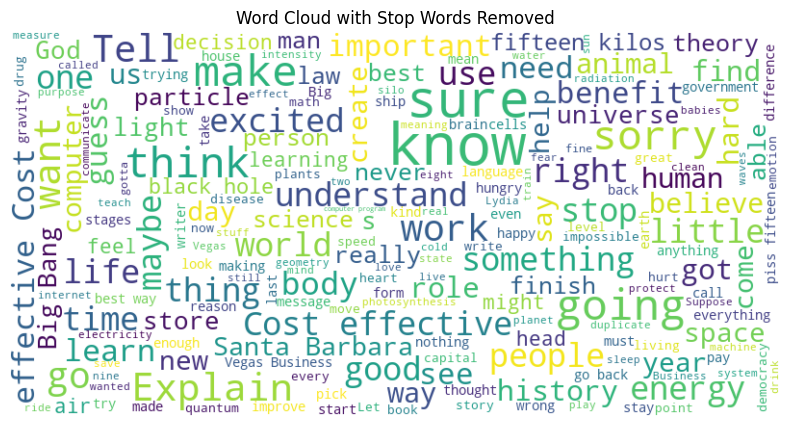

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import random
import time

# Add your own custom stop words along with default stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["that's", "i'm", "you're", "can't", "it's", "don't", "let's", "you're", "we're", "what's"])

# mixed prompts commonly asked to chatbots
prompts = [
    "How are you?", "What is the weather today?", "Tell me a joke.",
    "Where is the nearest hospital?", "Can you explain photosynthesis?", "Teach me algebra.",
    "How do I get over my fears?", "Tell me a story.", "What is the capital of Germany?",
    "What is love?", "How does the internet work?", "Help me create a short story.",
    "Explain how airplanes fly.", "What should I do when I'm bored?", "How do I start learning Python programming?",
    "What is the theory of evolution?", "How does gravity affect objects?", "Can you recommend a book?",
    "What is blockchain technology?", "How do rockets work?", "What is artificial intelligence?",
    "Explain the formation of black holes.", "What is quantum superposition?",
    "Why do cats purr?", "Can you explain quantum mechanics?", "How do I cook a steak?",
    "How do plants grow?", "What is democracy?", "What happens in a supernova?",
    "What is the purpose of life?", "What is photosynthesis?", "Who was Albert Einstein?",
    "Why do humans need to sleep?", "What is the role of governments in society?",
    "What are the benefits of meditation?", "Can you help me manage stress?", "Tell me about space exploration.",
    "What are the stages of a star's life?", "Who invented the telephone?", "How does the brain process emotions?",
    "Why do humans dream?", "What is DNA?", "Why is the sky blue?", "How do I improve my memory?",
    "What are the effects of climate change?", "Explain the difference between weather and climate.",
    "Why is math important?", "What is a computer's CPU?", "Can you help me create a meal plan?",
    "Why do stars twinkle?", "How does blockchain work?", "What is cryptocurrency?",
    "Why do we have seasons?", "What is the speed of light?", "How do bees make honey?",
    "Tell me the history of computers.", "What is the role of the internet?",
    "How does electricity flow?", "What is quantum theory?", "How do vaccines work?",
    "What is the best way to learn a new language?", "How does the immune system protect the body?",
    "How does a plane stay in the air?", "Explain the Big Bang theory.", "What is renewable energy?",
    "What are the benefits of physical exercise?", "How do computers store data?",
    "Explain the structure of the solar system.", "Why are oceans important?",
    "What are the symptoms of a common cold?", "What is the greenhouse effect?",
    "Why are forests important to the ecosystem?", "Who was Isaac Newton?", "What is quantum computing?",
    "Can you teach me about algebra?", "How do I solve quadratic equations?",
    "What is the role of genetics in evolution?", "Explain how GPS works.", "What are the benefits of recycling?",
    "How can I improve my public speaking skills?", "What is the history of jazz music?",
    "How do volcanoes form?", "What is machine learning?", "What is the meaning of life?",
    "What are the layers of the Earth's atmosphere?", "How does the digestive system work?",
    "What is the function of the heart?", "Why do animals hibernate?",
    "What are the principles of democracy?", "How do I calculate interest on a loan?",
    "Why is math used in physics?", "What is quantum tunneling?", "Can you explain the multiverse theory?",
    "What is artificial selection?", "Why is the Mona Lisa so famous?", "How does GPS track locations?",
    "What is an atom?", "What are black holes?", "Can you explain string theory?",
    "What is the difference between a democracy and a republic?", "Explain photosynthesis in detail.",
    "Why are polar bears endangered?", "What are the benefits of a healthy diet?",
    "How does electricity power cities?", "Why do humans feel emotions?",
    "Can you teach me basic chemistry?", "How do airplanes generate lift?",
    "What are the most important elements in the periodic table?", "Why is climate change a global issue?",
    "What is entropy in physics?", "How do planets form?", "What are the effects of gravity on light?",
    "Why is the moon important to Earth?", "Explain the importance of coral reefs.",
    "What are the stages of human development?", "How do rockets reach space?",
    "How does the stock market work?", "What is the history of mathematics?",
    "Can you explain the role of mitochondria in cells?", "What are Newton's laws of motion?",
    "How do plants use sunlight?", "Explain the role of the ozone layer.", "What is the speed of sound?",
    "How do submarines work?", "What are the elements of a story?", "What are the properties of magnets?",
    "How does the human brain store memories?", "Explain the science of thermodynamics.",
    "What is the role of proteins in the human body?", "How do we measure the size of the universe?",
    "What is your name?", "Tell me something interesting.", "How do you cook an egg?", "What is the best way to stay healthy?",
    "How are you feeling today?", "Can you help me with my math homework?", "What’s the fastest way to travel?",
    "What’s your favorite color?", "Why do we dream?", "Who invented the telephone?",
    "What is artificial intelligence?", "Explain the theory of evolution.", "How do airplanes stay in the air?",
    "Tell me a joke.", "What is the speed of light?", "What’s your favorite movie?",
    "How do I start learning Python?", "What is blockchain technology?", "Explain how photosynthesis works.",
    "Can you help me improve my public speaking?", "Why is the sky blue?", "What is a black hole?",
    "How does gravity work?", "Who won the last World Cup?", "Tell me a story about a dragon.",
    "How do I improve my time management?", "Why do birds migrate?", "What are the benefits of meditation?",
    "How do I tie a tie?", "Why do people lie?", "What are the benefits of a healthy diet?",
    "Explain quantum mechanics in simple terms.", "How do I start a business?", "What is the capital of Japan?",
    "How does the internet work?", "Can you explain the stock market?", "What is climate change?",
    "What is democracy?", "How can I reduce stress?", "What’s the tallest mountain in the world?",
    "Why is sleep important?", "What is the meaning of life?", "Tell me about the history of the United States.",
    "Who discovered electricity?", "What is cryptocurrency?", "How do vaccines work?",
    "Why do we need to drink water?", "What is renewable energy?", "How can I become a better listener?",
    "Tell me a fun fact about space.", "How do computers store information?", "What are the main ingredients of bread?",
    "What is the greenhouse effect?", "How do I create a website?", "Can you help me write a resume?",
    "What is the best way to learn a new language?", "What are the effects of pollution on oceans?",
    "Who was Albert Einstein?", "How does photosynthesis benefit humans?", "Explain the process of human digestion.",
    "Why do we feel emotions?", "How does a computer's CPU work?", "What are the symptoms of the flu?",
    "Tell me a short story about friendship.", "What are the different types of renewable energy?",
    "Why is art important to society?", "What are black holes?", "How do bees make honey?",
    "What are the stages of human development?", "What’s the purpose of government?",
    "Why do we have seasons?", "How does the immune system protect the body?", "Why do humans need to sleep?",
    "Explain the Big Bang theory.", "What are the benefits of exercise?", "How do I overcome procrastination?",
    "What is entropy?", "What is quantum superposition?", "Tell me how rockets work.",
    "How can I improve my memory?", "What’s your favorite book?", "Explain how airplanes generate lift.",
    "Why is math important?", "Tell me about the history of the internet.", "What is artificial selection?",
    "What is a supernova?", "How do animals communicate?", "How do submarines work?",
    "How can I improve my critical thinking skills?", "What are the principles of democracy?",
    "What’s the best way to stay fit?", "How do you solve quadratic equations?", "Explain how light travels through space.",
    "Why do stars twinkle?", "How do volcanoes form?", "What is the role of mitochondria in cells?",
    "What is the future of technology?", "How do rockets escape Earth’s atmosphere?", "What are the benefits of recycling?",
    "What is gravity?", "Why is the sky blue?", "Can you tell me about the solar system?",
    "How do we measure time?", "What is the history of jazz music?", "What are the effects of climate change?",
    "How do computers communicate?", "What are Newton’s laws of motion?", "How does the brain store memories?",
    "Why is the moon important?", "What are the different types of energy?", "How can I become a better leader?",
    "Tell me a fun fact about animals.", "What is renewable energy?", "How do airplanes fly?",
    "Why do humans have emotions?", "How do I write a business plan?", "What’s the best way to learn a new skill?",
    "Why do humans need water?", "How does the heart pump blood?", "What is the role of DNA in genetics?",
    "Why are coral reefs important?", "Tell me about the history of computers.", "What are the stages of a star's life?",
    "Explain how the internet works.", "Why do humans create art?", "How do computers store data?",
    "Why do we need governments?", "What are the benefits of learning a new language?", "How does blockchain technology work?",
    "What is a democracy?", "What are the benefits of physical exercise?", "What is the greenhouse effect?",
    "What are the symptoms of a common cold?", "How do volcanoes erupt?", "What is the speed of sound?",
    "What is quantum computing?", "How do submarines navigate underwater?", "How does a plane stay in the air?",
    "Explain the history of the Roman Empire.", "Why do some animals hibernate?", "What is the role of the ozone layer?",
    "How do vaccines help protect against disease?", "What is the theory of relativity?", "How does the brain process information?",
    "What are the benefits of meditation?", "What is the significance of the Renaissance?", "Why do humans need to eat?",
    "Tell me how clouds form.", "How does electricity power cities?", "Why do we need oxygen?",
    "Explain the Big Bang theory in simple terms.", "How do planets form?", "What is artificial intelligence?",
    "What is the role of education in society?", "How do I learn algebra?", "What is the purpose of art?",
    "What is the role of governments in public health?", "How does gravity affect objects?", "What is the history of mathematics?",
    "How do bees pollinate flowers?", "What are the different types of renewable energy?", "How do humans generate electricity?",
    "What is quantum tunneling?", "What is the role of the United Nations?", "What is photosynthesis?",
    "How do you solve a Rubik’s Cube?", "What is the role of proteins in the body?", "How does the immune system work?",
    "What is entropy in physics?", "Why do some animals migrate?", "How do I improve my public speaking skills?",
    "What are black holes?", "What is the speed of light?", "What is the history of space exploration?",
    "Explain how a computer works.", "How do I cook pasta?", "What are the benefits of a healthy diet?",
    "How do you play chess?", "What is string theory?", "How do I get better at math?",
    "What is the greenhouse effect?", "Explain how neural networks work.", "What are the benefits of recycling?",
    "Why do we need to drink water?", "Tell me about the history of the universe.", "What are the principles of economics?",
    "How do airplanes stay in the air?", "How does the brain store memories?", "Explain the function of the heart in the human body.",
    "What is artificial selection?", "What is the role of the brain in emotions?", "How do plants use sunlight?",
    "What is blockchain technology?", "Explain the science of thermodynamics.", "What is machine learning?",
    "How do humans generate electricity?", "What are the stages of human development?", "How do we measure the size of the universe?",
    "What is the meaning of life?", "How do rockets work?", "What is artificial intelligence?",
    "Explain how plants grow.", "How do I improve my memory?", "What is the speed of sound?",
    "How do you play the guitar?", "What are the properties of magnets?", "Why do we experience emotions?",
    "How do animals communicate?", "Explain how clouds form.", "What is the history of space exploration?",
    "What is the history of space exploration?", "Why do humans need sleep?", "How do computers communicate?",
    "What is a supernova?", "What are the effects of pollution?", "What are the layers of the Earth's atmosphere?",
    "How do we measure the size of the universe?", "What is the role of governments?",
    "Explain the formation of black holes.", "Why do stars twinkle?", "What are the benefits of exercise?",
    "Why is math important?", "What is the role of mitochondria in cells?", "How does gravity work?",
    "How do we measure the size of the universe?", "What is blockchain technology?", "How does gravity work?",
    "How do planes generate lift?", "What are the effects of climate change?", "How do airplanes fly?",
    "What is renewable energy?", "How do computers communicate?", "How do humans communicate?",
    "What's the weather like today?", "How do I change my password?", "Tell me a joke.", "What time is it?",
    "How do I reset my phone?", "What's the best restaurant nearby?", "How do I tie a tie?",
    "Can you recommend a good movie?", "What is quantum computing?", "What is the capital of Japan?",
    "How do I bake a cake?", "What is the meaning of life?", "What does the stock market do?",
    "Tell me a fun fact.", "How do I meditate?", "What's the population of the United States?",
    "How do I delete my account?", "Explain artificial intelligence.", "What is the fastest animal in the world?",
    "How do I cook pasta?", "Tell me something interesting about space.", "What is cryptocurrency?",
    "What's the tallest mountain in the world?", "How do I start a business?", "What's my current location?",
    "What is the square root of 144?", "Can you translate this sentence?", "What is the longest river in the world?",
    "How do I sign out of my account?", "What's the difference between HTTP and HTTPS?", "Why is the sky blue?",
    "How do I fix a slow computer?", "What is the latest news?", "What time is sunset today?",
    "How do I stop procrastinating?", "What are the benefits of yoga?", "What is the most expensive city to live in?",
    "How do I get to the nearest coffee shop?", "What's the definition of democracy?", "Who won the last soccer game?",
    "What does HTML stand for?", "How do I write a cover letter?", "What is the best way to lose weight?",
    "How do I create a website?", "What is climate change?", "What's the most common password?",
    "How do I cancel my subscription?", "What is virtual reality?", "How do I create a PDF?",
    "What are the symptoms of flu?", "How do I update my software?", "What is the best way to learn coding?",
    "Can you teach me how to swim?", "What is the best exercise for abs?", "What's the current exchange rate?",
    "Who is the richest person in the world?", "How do I backup my files?", "What's the easiest way to save money?",
    "How do I write a resume?", "How do I find a job?", "What's the fastest way to learn a language?",
    "How do I get rid of a virus on my computer?", "What is machine learning?", "What is the best travel destination?",
    "How do I overcome anxiety?", "What's the best time to go running?", "How do I book a flight?",
    "What are the symptoms of anxiety?", "How do I reset my router?", "What is the hardest language to learn?",
    "How do I play chess?", "What are the best mobile apps?", "How do I clean my keyboard?",
    "What's the difference between iOS and Android?", "How do I learn to play guitar?", "What's the best way to quit smoking?",
    "How do I improve my public speaking?", "What is the tallest building in the world?", "How do I set an alarm?",
    "What's the most popular social media platform?", "How do I stop junk mail?", "How do I install an app?",
    "What is a recession?", "How do I use a VPN?", "What are the best restaurants in New York?",
    "How do I recover my deleted files?", "How do I stop my phone from overheating?", "What are the most important life skills?",
    "How do I improve my memory?", "What are the benefits of meditation?", "How do I write a business plan?",
    "What's the difference between a tablet and a laptop?", "Can you help me find a nearby pharmacy?",
    "How do I deal with stress?", "What is the best way to save money?", "How do I delete my browsing history?",
    "What's a good recipe for dinner?", "How do I make a reservation at a restaurant?",
    "What's the fastest way to get to the airport?", "What is the best smartphone of 2024?",
    "How do I fix a slow internet connection?"
]

# Initialize an empty list to store chatbot responses
generated_responses = []
response_times = []  # List to store the generation times

# Generate chatbot responses for all prompts and measure response time
for prompt in prompts:
    start_time = time.perf_counter()  # Start timing

    response = generate_response(prompt)  # Replace with your actual chatbot response function

    end_time = time.perf_counter()  # End timing

    generated_responses.append(response)
    response_times.append(end_time - start_time)  # Store the generation time

# Join all the responses into one large string for word cloud generation
response_text = " ".join(generated_responses)

# Generate and display the word cloud with more even word size distribution, removing stop words
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_font_size=75,  # Set lower max font size for smoother word size distribution
    relative_scaling=0.6,  # Reduce the dominance of frequent words
    prefer_horizontal=0.8,  # Most words will be horizontal for better readability
    stopwords=custom_stopwords  # Remove common stop words and any custom words
).generate(response_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud with Stop Words Removed")
plt.show()

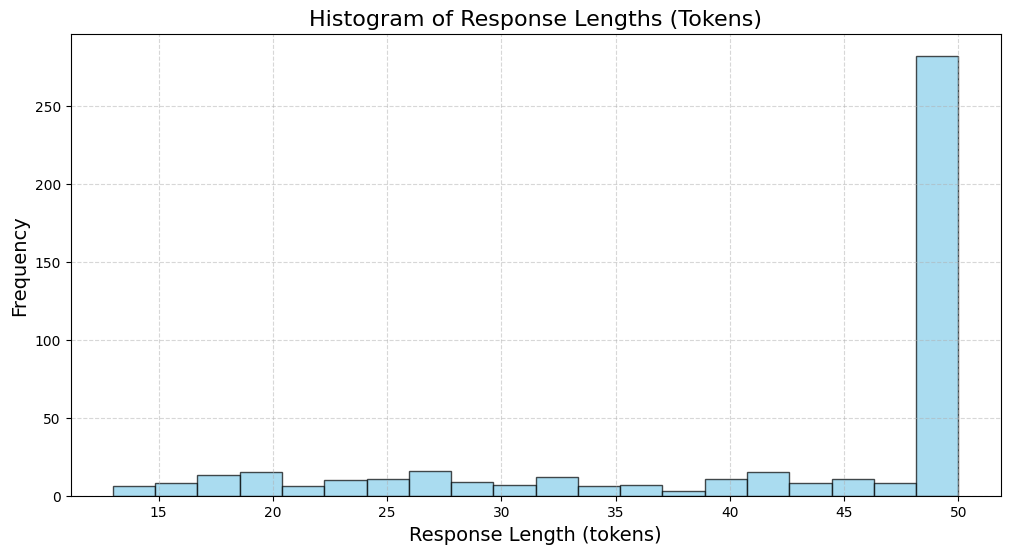

In [ ]:
# Function to calculate response Length (in terms of tokens)
def response_length(text):
    return len(tokenizer.tokenize(text))

# Get the lengths of each generated response
response_lengths = [response_length(pred) for pred in generated_responses]

# Plot a refined histogram of response lengths
plt.figure(figsize=(12, 6))  # Bigger figure for clarity
plt.hist(response_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)  # More bins for finer distribution
plt.title('Histogram of Response Lengths (Tokens)', fontsize=16)
plt.xlabel('Response Length (tokens)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid for better readability
plt.show()

**Analysis on Prompt Diversity**


Our analysis of the response lengths (in tokens) across a diverse range of prompts shows that most responses approach the cap of 50 tokens, this shows that our model prefers lengthier responses, likely due to the data augmentation we did prior.

We also generated a word cloud to visualize the most frequently used words in the chatbot's responses after removing common stopwords. Our analysis shows that words like "know," "think," "sure," and "life" are prominent, reflecting a conversational tone with a focus on understanding ann inquiry. Additionally, phrases such as "cost effective" and "black hole" highlight the model's ability to cover a wide range of topics. This demonstrates that the model is responding to a variety of topics, but seems to favor questions of inquiry.

### Time Analysis

#### Time Analysis on Prompt Diversity Test

This shows the response times from our previous diversity test

Average Generation Time: 0.64686 seconds


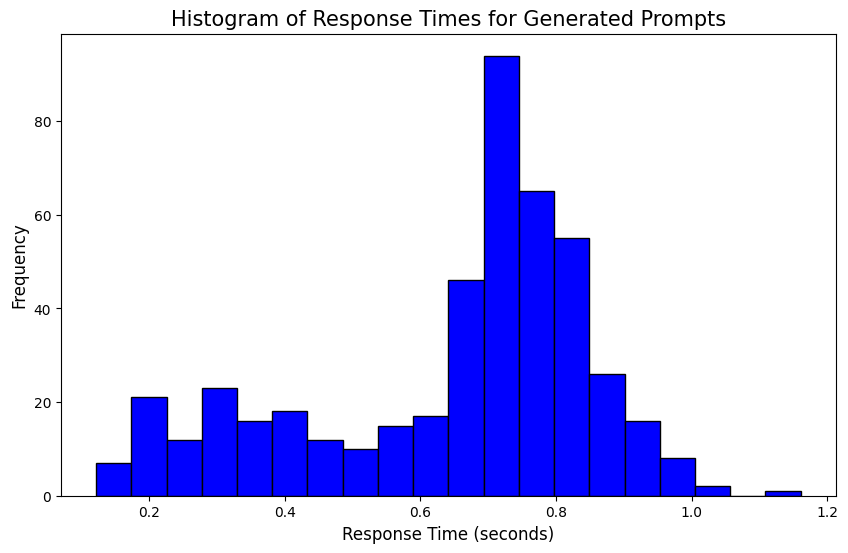

In [ ]:
# Calculate and print the average generation time
average_generation_time = sum(response_times) / len(response_times)
print(f"Average Generation Time: {average_generation_time:.5f} seconds")

# Plot the histogram for response times
plt.figure(figsize=(10, 6))
plt.hist(response_times, bins=20, color='blue', edgecolor='black')  # Customize bins as needed

# Add titles and labels
plt.title("Histogram of Response Times for Generated Prompts", fontsize=15)
plt.xlabel("Response Time (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()


#### Average Time on Single Prompt

This shows the average response time from the general promt ""How's the weather today?"

In [ ]:
import time

def generate_response(prompt):
    # Encode input and move it to the correct device
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)  # Create attention mask and move to GPU

    # Generate response with the model
    output = model.generate(input_ids, max_length=50, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    return response

# Function to measure the average inference time for a given prompt
def measure_inference_time(prompt, runs=10):
    total_time = 0
    for _ in range(runs):
        start_time = time.time()
        _ = generate_response(prompt)  # Call the response generation function
        end_time = time.time()
        total_time += (end_time - start_time)
    avg_time = total_time / runs
    return avg_time

# Test prompt for measuring inference time
test_prompt = "How's the weather today?"
average_inference_time = measure_inference_time(test_prompt)
print(f"Average inference time: {average_inference_time:.2f} seconds")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average inference time: 0.41 seconds


**Time Analysis**

Our time data shows our model is able to respond in reasonable time frames of around half a second.

## Evaluation Metrics and Performance Analysis

Explanation:

These metrics provide different perspectives on how well our model-generated text aligns with a reference.
- BLEU focuses on word and phrase overlap, measuring how similar the generated text is to the reference based on n-gram matches.
- ROUGE captures word overlap and sentence structure similarity, with variations like ROUGE-1 (single words) and ROUGE-L (longest common subsequence).
- METEOR goes beyond exact matches by considering synonyms and word order, making it more flexible for capturing meaning.
- Finally, our BERTScore evaluates the semantic similarity between generated and reference texts using word embeddings, providing a deeper understanding of meaning alignment.

Together, these metrics assess both surface-level similarity and deeper contextual understanding.

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
import evaluate
from bert_score import score as bert_score
import torch

# Download the 'punkt' tokenizer data
nltk.download('punkt')

# Initialize lists to store reference and generated responses
reference_responses = []
generated_responses = []

# Function to left-pad input_ids if necessary
def left_pad_tensor(tensor, pad_token_id):
    max_length = tensor.size(1)
    mask = (tensor != pad_token_id).long()
    lengths = mask.sum(dim=1)

    # Create a new tensor for left-padded input
    padded_tensor = torch.full_like(tensor, pad_token_id)

    for i, length in enumerate(lengths):
        padded_tensor[i, -length:] = tensor[i, :length]

    return padded_tensor

# Apply left-padding on input_ids and generate responses
for batch in test_dataloader:
    input_ids = batch.to(device)  # The batch is already tokenized

    # Ensure left-padding
    input_ids = left_pad_tensor(input_ids, tokenizer.pad_token_id)
    attention_mask = (input_ids != tokenizer.pad_token_id).to(device)  # Create attention mask

    # Generate response from the model
    output = model.generate(input_ids, max_new_tokens=50, attention_mask=attention_mask)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Decode the input to get reference responses (if necessary, adjust as per test set structure)
    reference_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    # Append the generated and reference responses
    generated_responses.append(generated_text)
    reference_responses.append(reference_text)

# Tokenize for BLEU scoring
tokenized_references = [[nltk.word_tokenize(ref.lower())] for ref in reference_responses]
tokenized_hypotheses = [nltk.word_tokenize(hyp.lower()) for hyp in generated_responses]

# Compute BLEU Score
bleu_score = corpus_bleu(tokenized_references, tokenized_hypotheses)
print(f'BLEU Score: {bleu_score * 100:.2f}')

# Compute ROUGE Scores using the 'evaluate' library
rouge = evaluate.load('rouge')
rouge_scores = rouge.compute(predictions=generated_responses, references=reference_responses)
for key in rouge_scores:
    print(f"{key.upper()} - Score: {rouge_scores[key] * 100:.2f}")

# Compute METEOR Score using the 'evaluate' library
meteor = evaluate.load('meteor')
meteor_score = meteor.compute(predictions=generated_responses, references=reference_responses)
print(f"METEOR Score: {meteor_score['meteor'] * 100:.2f}")

# Compute BERTScore (ensure it runs on GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
P, R, F1 = bert_score(generated_responses, reference_responses, lang='en', verbose=False, device=device)
average_f1 = F1.mean().item()
print(f"BERTScore F1: {average_f1 * 100:.2f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to

BLEU Score: 92.00
ROUGE1 - Score: 96.61
ROUGE2 - Score: 96.49
ROUGEL - Score: 96.61
ROUGELSUM - Score: 96.62


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 98.39


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore F1: 99.39


#### Examples of Reference and Generated Responses For Visual Comparion

In [ ]:
for response in reference_responses[0:5]:
    print(response)

Yeah. Good.  Thought I was imagining them. You see that?
Not on the same floor with Valentino! Just follow me. Careful, it's slippery.  I had it waxed.
Julie, we're talkin' suites!  That'll be just fine with us. And, while you're here, our marginally trained, off-season staff of five will attend to your every need. Not at all. Those are our honeymoon suites.
Poly-what? Have we ever met before? It's polyester.
I'm sorry Mom canned you. It's really... not anything, Lainey.  It's just -- Hello, sweetheart.


In [ ]:
for response in generated_responses[0:5]:
    print(response)

Yeah. Good.  Thought I was imagining them. You see that?
Not on the same floor with Valentino! Just follow me. Careful, it's slippery.  I had it waxed.
Julie, we're talkin' suites!  That'll be just fine with us. And, while you're here, our marginally trained, off-season staff of five will attend to your every need. Not at all. Those are our honeymoon suites.
Poly-what? Have we ever met before? It's polyester.
I'm sorry Mom canned you. It's really... not anything, Lainey.  It's just -- Hello, sweetheart.  I'm Jimmy.  I'm so happy for you.  I'm so relieved you said yes, and I'm really, um, what, thrilled, yes actually, to finally meet you.


#### **Analysis on Evaluation Metrics and Final Thoughts on Tests**

Our model achieved strong results across all key evaluation metrics, showcasing its high level of performance:

- A **BLEU score of 92.00** indicates excellent n-gram overlap between generated and reference texts, reflecting the model's ability to produce similar phrasing.
- **ROUGE scores**—including **ROUGE-1 (96.61), ROUGE-2 (96.49), and ROUGE-L (96.61)**—demonstrate strong word overlap and sentence structure similarity.
- A **METEOR score of 98.39** further highlights the model’s flexibility in capturing meaning through synonyms and word order.
- Finally, a **BERTScore F1 of 99.39** reveals that the model’s generated responses are almost perfectly semantically aligned with reference texts, showcasing a deep understanding of context.

Overall, these high scores confirm that the model effectively generates responses that sound like natural movie dialogues. While individual responses might still leave something to be desired, our overall tests results suggest the model performs impressively well in replicating the conversational tone and structure expected from movie characters.

# LIVE DEMOS

ipywidgets-based Test (For Jupyter Notebooks):

In [ ]:
from ipywidgets import interact_manual, Textarea

def chat_bot():
    @interact_manual(input_text=Textarea(value='', placeholder='Type your message here...', description='User:', disabled=False))
    def generate_chatbot_response(input_text):
        # Move input to GPU or CPU depending on setup
        input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
        attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

        # Generate response with repetition control
        output = model.generate(
            input_ids,
            max_length=50,
            attention_mask=attention_mask,
            num_return_sequences=1,
            no_repeat_ngram_size=3,      # Avoid repeating sequences
            repetition_penalty=1.5,      # Penalty for repetition
            temperature=0.7,             # More creative generation
            top_p=0.9                    # Nucleus sampling
        )
        response = tokenizer.decode(output[0], skip_special_tokens=True)

        print(f"Chatbot: {response}")

chat_bot()

interactive(children=(Textarea(value='', description='User:', placeholder='Type your message here...'), Button…

# Gradio

In [ ]:
import gradio as gr

# Function to generate response
def gradio_response(prompt):
    # Move input to GPU or CPU depending on your setup
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

    # Generate response
    output = model.generate(input_ids, max_length=50, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    return response

# Set up Gradio Interface
interface = gr.Interface(fn=gradio_response, inputs="text", outputs="text")
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8f2cd92b91d34ace51.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#Closes Gradio
interface.close()

Closing server running on port: 7860


# Conclusion

This project involved three rounds of training to fine-tune a generative chatbot using GPT-2, with a primary goal of improving fluency and coherence in dialogue generation. Initially, our first round of training over 4 epochs yielded poor results, with the chatbot unable to generate coherent or relevant responses. However, in a second round of 13 epochs, the model showed some improvement in generating more meaningful responses, although it still struggled with maintaining context and relevance across turns.

Finally, after training for 31 epochs, the chatbot demonstrated significant improvements, as reflected by strong performance across key metrics such as a **BLEU score of 92.00**, **ROUGE-1 of 96.61**, and a **BERTScore F1 of 99.39**. These scores indicate a strong overlap with reference texts and demonstrate the model's ability to generate lexically and semantically appropriate responses. The **METEOR score of 98.39** further highlights the model's capacity to capture meaning through varied phrasing.

Despite these improvements, the model still lacks depth and consistency in multi-turn conversations, often losing track of context over extended dialogues. Based on our loss chart, we believe several more rounds of training with a high number of epochs would improve the model, including potential adjustments to hyperparameters like the learning rate and batch size,. Additionally, using sentiment analysis to filter out some of the more negative conversations, combined with additional augmentation of more mid-size dialogues to properly tune it for more a conversational tone.